In [2]:
import wcs_footprint_visualizer as wfv
import numpy as np

from astropy.modeling import models
from astropy import coordinates as coord
from astropy import units as u

from gwcs import WCS
from gwcs import coordinate_frames as cf
from adjustText import adjust_text

from stcal.alignment.util import (
    wcs_from_footprints,
)

In [3]:
# print all output from a single cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

%matplotlib inline

In [4]:
class WcsInfo:
    def __init__(self, ra_ref, dec_ref, roll_ref, v2_ref, v3_ref, v3yangle):
        self.ra_ref = ra_ref
        self.dec_ref = dec_ref
        self.ctype1 = "RA---TAN"
        self.ctype2 = "DEC--TAN"
        self.v2_ref = v2_ref
        self.v3_ref = v3_ref
        self.v3yangle = v3yangle
        self.roll_ref = roll_ref
        self.vparity = -1
        self.wcsaxes = 2


class Coordinates:
    def __init__(self):
        self.reference_frame = "ICRS"


class MetaData:
    def __init__(
        self, ra_ref, dec_ref, roll_ref, v2_ref, v3_ref, v3yangle, wcs=None
    ):
        self.wcsinfo = WcsInfo(
            ra_ref, dec_ref, roll_ref, v2_ref, v3_ref, v3yangle
        )
        self.wcs = wcs
        self.coordinates = Coordinates()


class DataModel:
    def __init__(
        self, ra_ref, dec_ref, roll_ref, v2_ref, v3_ref, v3yangle, wcs=None
    ):
        self.meta = MetaData(
            ra_ref, dec_ref, roll_ref, v2_ref, v3_ref, v3yangle, wcs=wcs
        )

In [31]:
def _create_wcs_object_without_distortion(
    fiducial_world,
    pscale,
    shape,
):
    # we should apply a shift when working with FITS, otherwise, it is not necessary
    shift = models.Shift() & models.Shift()

    scale = models.Scale(pscale[0]) & models.Scale(pscale[1])

    tan = models.Pix2Sky_TAN()
    celestial_rotation = models.RotateNative2Celestial(
        fiducial_world[0],
        fiducial_world[1],
        180,
    )

    det2sky = shift | scale | tan | celestial_rotation
    det2sky.name = "linear_transform"

    detector_frame = cf.Frame2D(
        name="detector", axes_names=("x", "y"), unit=(u.pix, u.pix)
    )
    sky_frame = cf.CelestialFrame(
        reference_frame=coord.FK5(), name="fk5", unit=(u.deg, u.deg)
    )

    pipeline = [(detector_frame, det2sky), (sky_frame, None)]

    wcs_obj = WCS(pipeline)

    wcs_obj.bounding_box = (
        (-0.5, shape[0] - 0.5),
        (-0.5, shape[1] - 0.5),
    )

    return wcs_obj

def _create_wcs_and_datamodel(fiducial_world, shape, pscale):
    wcs = _create_wcs_object_without_distortion(
        fiducial_world=fiducial_world, shape=shape, pscale=pscale
    )
    ra_ref, dec_ref = fiducial_world[0], fiducial_world[1]
    return DataModel(
        ra_ref=ra_ref,
        dec_ref=dec_ref,
        roll_ref=0,
        v2_ref=0,
        v3_ref=0,
        v3yangle=0,
        wcs=wcs,
    )

(4, 4)

[4, 4]

(9.999999999999998, 0.0)

(9.999972000000003, -2.7999999996212126e-05)

(10.000070000000015, -4.199999999900127e-05)

4

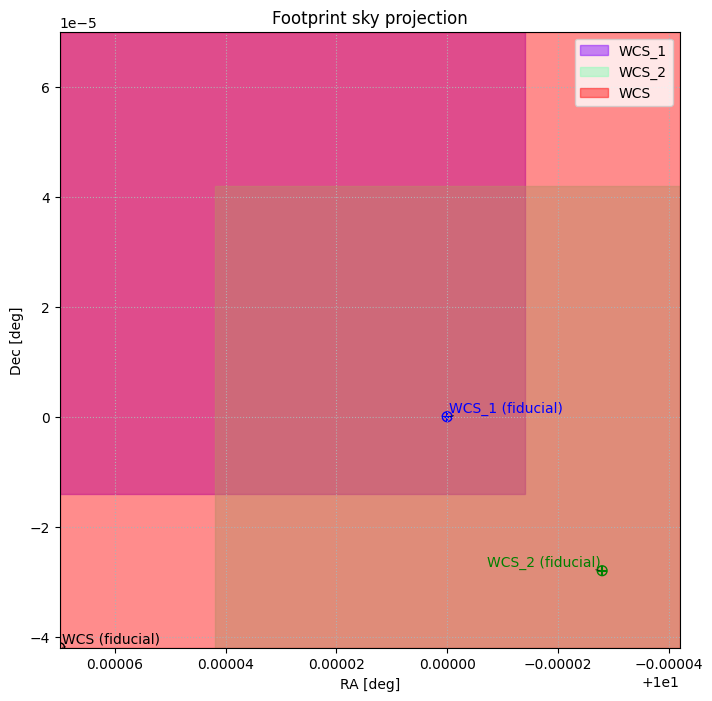

In [32]:
shape = (3, 3)  # in pixels
fiducial_world = (10, 0)  # in deg
pscale = (0.000028, 0.000028)  # in deg/pixel

dm_1 = _create_wcs_and_datamodel(fiducial_world, shape, pscale)
wcs_1 = dm_1.meta.wcs

# shift fiducial by the size of a pixel projected onto the sky in both directions
# and create a new WCS
fiducial_world = (
    fiducial_world[0] - 0.000028,
    fiducial_world[1] - 0.000028,
)
dm_2 = _create_wcs_and_datamodel(fiducial_world, shape, pscale)
wcs_2 = dm_2.meta.wcs

wcs = wcs_from_footprints([dm_1, dm_2])

# visualization
wcs_1.name = "WCS_1"
wcs_2.name = "WCS_2"
wcs.name = "WCS"
wcs.pixel_shape
wcs.array_shape

# WCS(0,0) should return the coordinates of the WCS's fiducial point
wcs_1(0, 0)
wcs_2(0, 0)
wcs(0, 0)

fig = wfv.plot([wcs_1, wcs_2, wcs])

# show wcs_1 fiducial point coordinates
fig.scatter([10], [0], marker="+", s=50, color="blue")
# show wcs_2 fiducial point coordinates
fig.scatter(fiducial_world[0], fiducial_world[1], marker="+", s=50, color="green")

# show wcs_1's pixel coordinate (0, 0)
fig.scatter(*wcs_1(0, 0), marker="o", facecolors="None", edgecolors="blue", s=50)
# show wcs_2's pixel coordinate (0, 0)
fig.scatter(*wcs_2(0, 0), marker="o", facecolors="None", edgecolors="green", s=50)
# show wcs's pixel coordinate (0, 0)
fig.scatter(*wcs(0, 0) , marker="o", facecolors="None", edgecolors="black", s=50)

# # show wcs_1's pixel coordinate (n, n)
fig.scatter(*wcs_1(shape[0], shape[1]), marker="o", facecolors="None", edgecolors="blue", s=50)
# # show wcs_2's pixel coordinate (n, n)
fig.scatter(*wcs_2(shape[0], shape[1]), marker="o", facecolors="None", edgecolors="green", s=50)

# add text labels
texts = [
    fig.text(*wcs(0, 0), s=f"WCS{id} (fiducial)", color=c)
    for wcs, id, c in [
        (wcs_1, "_1", "blue"), (wcs_2, "_2", "green"), (wcs, "", "black")
    ]
]
adjust_text(texts, arrowprops=dict(arrowstyle="-", color="k", lw=0.5))

In [7]:
wcs.footprint()

array([[ 1.000007e+01, -4.200000e-05],
       [ 1.000007e+01,  7.000000e-05],
       [ 9.999958e+00,  7.000000e-05],
       [ 9.999958e+00, -4.200000e-05]])

The combined WCS will have its vertices matching up with the footprint:

In [18]:
assert all(np.isclose(wcs.footprint()[0], wcs(0, 0)))
assert all(np.isclose(wcs.footprint()[1], wcs(0, 4)))
assert all(np.isclose(wcs.footprint()[2], wcs(4, 4)))
assert all(np.isclose(wcs.footprint()[3], wcs(4, 0)))

In [36]:
[wcs(2.5, 1.5), wcs_1(0, 0)], [wcs(3.5, 0.5), wcs_2(0, 0)]

([(10.00000000000003, -2.593838713986836e-14), (9.999999999999998, 0.0)],
 [(9.999972000000053, -2.8000000002311735e-05),
  (9.999972000000003, -2.7999999996212126e-05)])

In [37]:
assert all(np.isclose(wcs(2.5, 1.5), wcs_1(0, 0)))
assert all(np.isclose(wcs(3.5, 0.5), wcs_2(0, 0)))

In [14]:
np.isclose(wcs(3.5, 0.5), wcs_2(0, 0))

array([ True,  True])